In [39]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.optim as optim

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.datasets import data_transforms
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# For handling file paths and directories
import os
import sys
import h5py

# Optional: If your model or data processing requires specific numerical operations (e.g., FFT)
from torch.fft import fft, ifft

# Optional: If you are working with graph data or architectures
# import torch_geometric

# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function


In [2]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.1.0


In [36]:
#Load the data for the neural operator model
datafolder_name = ["OUTPUT","preliminary_datasets"]
datafile_name = "DATA N_pix32x32 N_ele1x1 N_wv25x13 N_disp100 N_eig6 offset0 01-Mar-2024 19-13-23.mat"
data_path = os.path.join(*datafolder_name, datafile_name)
print(data_path)

# Load the .mat file using h5py
with h5py.File(data_path, 'r') as file:
    # print(file['EIGENVECTOR_DATA'].dtype.names)
    # print(file['EIGENVALUE_DATA'].dtype.names)
    # print(file['WAVEVECTOR_DATA'].dtype.names)
    # Load the data arrays
    EIGENVALUE_DATA = np.array(file['EIGENVALUE_DATA'])
    EIGENVECTOR_DATA_real = np.array(file['EIGENVECTOR_DATA']['real'])
    EIGENVECTOR_DATA_imag = np.array(file['EIGENVECTOR_DATA']['imag'])
    EIGENVECTOR_DATA = EIGENVECTOR_DATA_real + 1j * EIGENVECTOR_DATA_imag
    WAVEVECTOR_DATA = np.array(file['WAVEVECTOR_DATA'])

    # Convert to PyTorch tensors
    EIGENVALUE_DATA_tensor = torch.tensor(EIGENVALUE_DATA, dtype=torch.float32)
    EIGENVECTOR_DATA_tensor = torch.tensor(EIGENVECTOR_DATA, dtype=torch.complex64)
    WAVEVECTOR_DATA_tensor = torch.tensor(WAVEVECTOR_DATA, dtype=torch.float32)

    # Unpack the 'const' struct
    # This assumes 'const' contains datasets directly. If it contains groups, you'll need to adjust the code
    const = {key: np.array(file['const'][key]) for key in file['const']}

    # Assign numbers to variables
    N_struct = np.array(file['N_struct'])  # Adjust indexing if necessary
    design_params = np.array(file['design_params'])
    designs = np.array(file['designs'])
    imag_tol = np.array(file['imag_tol'])
    rng_seed_offset = np.array(file['rng_seed_offset'])

OUTPUT\preliminary_datasets\DATA N_pix32x32 N_ele1x1 N_wv25x13 N_disp100 N_eig6 offset0 01-Mar-2024 19-13-23.mat


In [34]:
# Print shapes or values to verify
print("EIGENVALUE_DATA shape:", EIGENVALUE_DATA_tensor.shape)
print("EIGENVECTOR_DATA shape:", EIGENVECTOR_DATA_tensor.shape) #Complex valued, 32x32 nodes, 2 DoF per node, 100 structs, 6 bands
print("WAVEVECTOR_DATA shape:", WAVEVECTOR_DATA_tensor.shape)
#print("const contents:", const)
print("N_struct:", N_struct)
print("design_params:", design_params)
print("designs:", designs)
print("imag_tol:", imag_tol)
#print("rng_seed_offset:", rng_seed_offset)

EIGENVALUE_DATA shape: torch.Size([100, 6, 325])
EIGENVECTOR_DATA shape: torch.Size([100, 6, 325, 2048])
WAVEVECTOR_DATA shape: torch.Size([100, 2, 325])
N_struct: 100.0
design_params: 3707764736
designs: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
imag_tol: 0.001


In [21]:
def plot_histograms(array_slice):
    """
    Plots histograms for the input array slice.
    If the array slice contains real numbers, plots one histogram.
    If the array slice contains complex numbers, plots two histograms side by side,
    one for the real parts and one for the imaginary parts.
    """
    # Check if the array slice contains complex numbers
    if np.iscomplexobj(array_slice):
        # Prepare the plot area with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Plot histogram of real parts
        axs[0].hist(array_slice.real, bins=100, color='skyblue', edgecolor='black')
        axs[0].set_title('Histogram of Real Parts')

        # Plot histogram of imaginary parts
        axs[1].hist(array_slice.imag, bins=100, color='salmon', edgecolor='black')
        axs[1].set_title('Histogram of Imaginary Parts')

        plt.suptitle('Histograms of Complex Array Slice')
    else:
        # Plot a single histogram for real-valued array slice
        plt.figure(figsize=(6, 6))
        plt.hist(array_slice, bins=30, color='skyblue', edgecolor='black')
        plt.title('Histogram of Real Array Slice')

    plt.show()

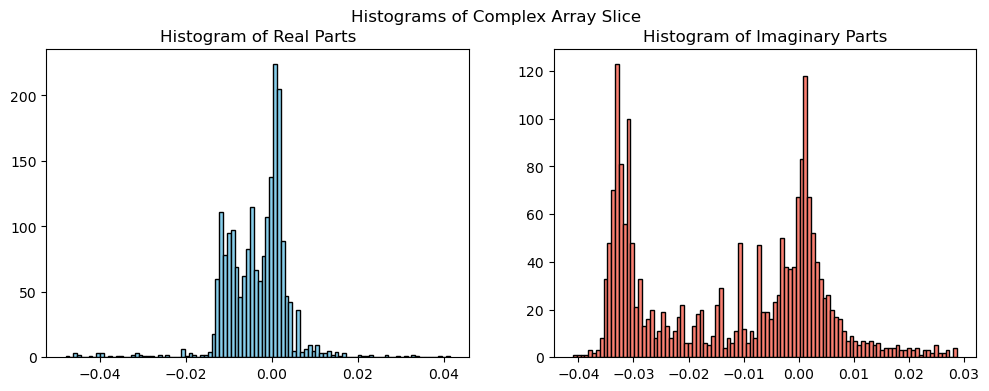

In [26]:
struct = 0
band = 0
wavevector = 300
node = 0
plot_histograms(EIGENVECTOR_DATA[struct, band, wavevector, :])
#plot_histograms(WAVEVECTOR_DATA[struct, 0, :])

In [69]:
NO_model = TFNO(n_modes=(16, 16), in_channels=3, out_channels=6, hidden_channels=32, projection_channels=16)
NO_model.to(device)
NO_params = count_model_params(NO_model)
print(f'Neural Operator model has {NO_params} parameters.')

Neural Operator model has 1212830 parameters.


In [42]:
class NormalizeOutput:
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

    def fit(self, outputs):
        """Calculate mean and std deviation from the dataset if not provided."""
        if self.mean is None or self.std is None:
            self.mean = outputs.mean(axis=0)
            self.std = outputs.std(axis=0)

    def transform(self, outputs):
        """Normalize the outputs."""
        return (outputs - self.mean) / self.std

    def inverse_transform(self, normalized_outputs):
        """Reverse the normalization to get the original scale of outputs."""
        return normalized_outputs * self.std + self.mean


In [45]:
# Use designs as x_train and EIGENVALUE_DATA as y_train
print("designs shape:", designs.shape)
print("EIGENVALUE_DATA shape:", EIGENVALUE_DATA.shape)
x_train = torch.tensor(designs, dtype=torch.float32)
y_train = torch.tensor(EIGENVALUE_DATA, dtype=torch.float32)

# Normalize the outputs
# normalizer = NormalizeOutput()
# normalizer.fit(y_train.numpy())
# normalized_outputs = normalizer.transform(y_train.numpy())
# y_train = torch.tensor(normalized_outputs, dtype=torch.float32)
# print(normalizer.mean, normalizer.std)

dataset = torch.utils.data.TensorDataset(x_train, y_train)
print(torch.max(x_train), torch.min(x_train))
print(torch.max(y_train), torch.min(y_train))
#print(len(dataset))
# Define the sizes of train and test datasets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

designs shape: (100, 3, 32, 32)
EIGENVALUE_DATA shape: (100, 6, 325)
tensor(1.) tensor(0.)
tensor(3856.4348) tensor(0.)


In [62]:
class DataLoaderWrapper:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        # Iterate over the original DataLoader
        for batch in self.dataloader:
            inputs, outputs = batch  # Unpack the batch
            # Yield a dictionary with 'inputs' and 'outputs' keys
            yield {'x': inputs, 'y': outputs}

    def __len__(self):
        # Return the length of the original DataLoader
        return len(self.dataloader)

In [63]:
train_loader_wrapped = DataLoaderWrapper(train_loader)
test_loader_wrapped = DataLoaderWrapper(test_loader)

In [70]:
optimizer = torch.optim.Adam(NO_model.parameters(),
                             lr=8e-3,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [71]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [72]:
print('\n### MODEL ###\n', NO_model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(32, 32, 16, 9))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(16, 6, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losse

In [73]:
trainer = Trainer(model=NO_model, n_epochs=1,
                  device=device,
                  #data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


In [74]:
trainer.train(train_loader=train_loader_wrapped,
              test_loaders=test_loader_wrapped,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)


RuntimeError: The size of tensor a (1024) must match the size of tensor b (1950) at non-singleton dimension 2

In [75]:
# Check the first batch from the train_loader
train_samples = next(iter(train_loader))
print(type(train_samples))
print(f"Length of batch: {len(train_samples)}")
if isinstance(train_samples, (list, tuple)):
    # Assuming the first element is inputs and the second is targets
    print(f"Type of inputs: {type(train_samples[0])}, Shape of inputs: {train_samples[0].shape}")
    print(f"Type of targets: {type(train_samples[1])}, Shape of targets: {train_samples[1].shape}")
elif isinstance(train_samples, dict):
    # If your samples are in a dictionary format
    for key, value in train_samples.items():
        print(f"Key: {key}, Type of value: {type(value)}, Shape of value: {value.shape}")

# Repeat the process for test_loader if necessary
test_samples = next(iter(test_loader))
# Similar inspection as above for test_samples...


<class 'list'>
Length of batch: 2
Type of inputs: <class 'torch.Tensor'>, Shape of inputs: torch.Size([20, 3, 32, 32])
Type of targets: <class 'torch.Tensor'>, Shape of targets: torch.Size([20, 6, 325])
